## 准备工作

### 引入各类库

In [1]:
### 引入所有包
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
from fake_useragent import UserAgent
import json
import time
import random
from urllib.parse import quote
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from PIL import Image,ImageEnhance
import hashlib
from collections import Counter
from gensim import corpora, models, similarities
import codecs, sys
import jieba
import os
import codecs
import shutil
from sklearn import feature_extraction  
from sklearn.feature_extraction.text import TfidfTransformer  
from sklearn.feature_extraction.text import CountVectorizer
from pdfminer.converter import PDFPageAggregator
from pdfminer.layout import LAParams
from pdfminer.pdfparser import PDFParser, PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfdevice import PDFDevice
import tensorflow as tf

### 将所有pdf文本，转化为表格

In [ ]:
### pdf转化器
def pdfreader(filename):
    """
    将pdf转化为text文本
    Param filename:文档名
    return final_test:最终文本内容列表
    """
    try:
        #获得文档对象,以二进制读方式打开
        fp = open(filename, "rb")

        #创建一个与文档关联的分析器
        parser = PDFParser(fp)

        #创建一个pdf文档的对象
        doc = PDFDocument()

        #连接解释器与文档对象
        parser.set_document(doc)
        doc.set_parser(parser)

        #初始化文档,如果文档有密码，写与此。
        doc.initialize("")

        #创建pdf资源管理器
        resource = PDFResourceManager()

        #参数分析器
        laparam = LAParams()

        #创建聚合器
        device = PDFPageAggregator(resource, laparams=laparam)

        #创建pdf页面解释器
        interpreter = PDFPageInterpreter(resource, device)

        #使用文档对象得到页面的集合
        list_text,corpus = [],[]
        for page in doc.get_pages():
            #使用页面解释器读取
            interpreter.process_page(page)
            #使用聚合器来获得内容
            layout = device.get_result()
            for out in layout:
                if hasattr(out, "get_text"):
                    line = out.get_text().strip("\n ")
                    line_clean = re.sub("\n","",line)
                    list_text.append(line_clean)
        final_test = "".join([i for i in list_text if i != ""])
        return final_test
    except Exception as e:
        pass

os.chdir("正当防卫的1000份文书")
file_list = os.listdir()
corpus = list(map(pdfreader,file_list))

### 文本清理，提取出所有的重要信息

In [ ]:
### 文本清理器1
def clean(corpus_none_n):
    
    # 正则表达式部分
    results = corpus_none_n
    ### 原告中的三类可能
    pattern_plaintiff = re.compile(r"原告：([\u4e00-\u9fa5].*?)，") # 原告第一类可能
    pattern_plaintiff_2 = re.compile(r"原告：([\u4e00-\u9fa5].*?)。") # 原告第二类可能
    pattern_plaintiff_3 = re.compile(r"原告.*?，") # 原告第三类可能

    ### 被告中的三类可能
    pattern_defender = re.compile(r"被告：.*?，")
    pattern_defender_2 = re.compile(r"被告：.*?。")

    ### 原告出生年龄
    pattern_plaintiff_birthday = re.compile(r"原告：.*\d.*?出生，")

    ### 被告出生年龄
    pattern_defender_birthday = re.compile(r"被告：.*\d.*?出生，")

    ### 立案时间
    pattern_starttime = re.compile(r"，本院于.*\d.立案后，")

    ### 诉讼请求
    pattern_claims = re.compile(r"诉讼请求：.*?。")
    pattern_claims_2 = re.compile(r"诉称，.*本院认为")

    ### 事实和理由
    pattern_facts = re.compile(r"事实和理由：.*。")

    ### 辩护事实
    pattern_defence = re.compile(r"辩称：.*")
    pattern_defence_2 = re.compile(r"辩称，.*")

    ### 法院认定事实
    pattern_court_fact_1 = re.compile(r"认定事实如下：.*。本院")
    pattern_court_fact_2 = re.compile(r"经审理查明：.*。本院")
    pattern_court_fact_3 = re.compile(r"经审理查明，.*。本院")

    ### 法院对事实的判定
    pattern_court_advise = re.compile(r"本院认为.*")

    ### 法院的意见
    pattern_court_attitude = re.compile(r"综上所述.*?。")

    ### 法条
    pattern_laws_1 = re.compile(r"《.*?》.*?条")
    pattern_laws_2 = re.compile(r"《.*?》.*?条，")

    ### 判决
    pattern_judgement = re.compile("判决如下:.*。") #需要使用去掉\n的文档

    ## 搜索原告
    def find_plaintiffs(text,pattern1,pattern2,pattern3):
        if re.search(pattern1,text):
            piece = re.search(pattern1,text).group().strip(":原告：，")
            return piece
        elif re.search(pattern2,text):
            piece = re.search(pattern2,text).group().strip(":原告：，")
            return piece
        elif re.search(pattern3,text):
            piece = re.search(pattern3,text).group().strip(":原告：，")
            return piece
        else:
            return None

    ## 搜索被告
    def find_defender(text,pattern1,pattern2):
        if re.search(pattern1,text):
            piece = re.search(pattern1,text).group().strip("被告：")
            return piece
        elif re.search(pattern2,text):
            piece = re.search(pattern2,text).group().strip("被告：")
            return piece
        else:
            return None

    ## 搜索原告出生年龄
    def find_plaintiffs_birthday(text,pattern):
        if re.search(pattern,text):
            piece = re.search(pattern,text).group().strip("，")
            text = re.sub("原告：.*，","",piece).strip("出生")
            return text
        else:
            return None

    ## 搜索被告出生年龄
    def find_defenders_birthday(text,pattern):
        if re.search(pattern,text):
            piece = re.search(pattern,text).group().strip("，")
            text = re.sub("被告：.*，","",piece).strip("出生")
            return text
        else:
            return None

    ## 立案时间
    def find_starttime(text,pattern):
        if re.search(pattern,text):
            piece = re.search(pattern,text).group().lstrip("，本院于").rstrip("立案后，")
            return piece
        else:
            return None

    ## 事实和理由
    def find_facts(text,pattern):
        if re.search(pattern,text):
            piece = re.search(pattern,text).group()
            return piece
        else:
            return None

    ## 被告辩称
    def find_defenders_words(text,pattern1,pattern2):
        if re.search(pattern1,text):
            piece = re.search(pattern1,text).group()
            return piece
        elif re.search(pattern2,text):
            piece = re.search(pattern2,text).group()
            return piece
        else:
            return None

    ## 法院认定事实
    def find_court_facts(text,pattern1,pattern2,pattern3):
        if re.search(pattern1,text):
            piece = re.search(pattern1,text).group().rstrip("本院")
            return piece
        elif re.search(pattern2,text):
            piece = re.search(pattern2,text).group().rstrip("本院")
            return piece
        elif re.search(pattern3,text):
            piece = re.search(pattern3,text).group().rstrip("本院")
            return piece
        else:
            return None

    ## 查找法条
    def find_laws(text,pattern1,pattern2):
        if re.search(pattern1,text):
            pieces = re.findall(pattern1,text)
            short_pieces_1 = list(filter(lambda x:len(x) < 50,pieces))
            pieces = re.findall(pattern2,text)
            short_pieces_2 = list(filter(lambda x:len(x) < 50,pieces))
            short_pieces = short_pieces_1 + short_pieces_2
            return short_pieces
        else:
            return None

    ## 大块文字专用
    def find_claims_or_blocks(text,pattern):
        if re.search(pattern,text):
            piece = re.search(pattern,text).group()
            return piece
        else:
            return None
    
    ## 原告诉求
    def find_claims(text,pattern1,pattern2):
        if re.search(pattern1,text):
            piece = re.search(pattern1,text).group()
            return piece
        elif re.search(pattern2,text):
            piece = re.search(pattern2,text).group()
            return piece
        
    ## 重复pattern，构造pattern list
    def repeat_pattern(pattern):
        pattern_lists = len(list(results)) * [pattern]
        return pattern_lists

    list_piece_t,list_corpus = [],[] 
    ### 是否这里可以改成(**kwargs)
    ### 原告
    
    plaintiffs = list(map(find_plaintiffs,corpus_none_n,repeat_pattern(pattern_plaintiff),
                          repeat_pattern(pattern_plaintiff_2),repeat_pattern(pattern_plaintiff_3)))

    ### 被告
    defenders = list(map(find_defender,corpus_none_n,repeat_pattern(pattern_defender),
                        repeat_pattern(pattern_defender_2)))
    
    ### 原告出生年龄
    plaintiffs_birthday = list(map(find_plaintiffs_birthday,corpus_none_n,repeat_pattern(pattern_plaintiff_birthday)))

    ###被告出生年龄
    defenders_birthday = list(map(find_defenders_birthday,corpus_none_n,repeat_pattern(pattern_defender_birthday)))

    ### 立案时间
    starttimes = list(map(find_starttime,corpus_none_n,repeat_pattern(pattern_starttime)))

    ### 诉讼请求
    claims = list(map(find_claims,corpus_none_n,repeat_pattern(pattern_claims),repeat_pattern(pattern_claims_2)))

    ### 事实与理由
    facts = list(map(find_claims_or_blocks,corpus_none_n,repeat_pattern(pattern_facts)))

    ### 被告辩称
    
    defences = list(map(find_defender,corpus_none_n,repeat_pattern(pattern_defence),
                        repeat_pattern(pattern_defence_2)))
    
    ### 法院认定事实
    court_facts = list(map(find_court_facts,corpus_none_n,repeat_pattern(pattern_court_fact_1),
                          repeat_pattern(pattern_court_fact_2),repeat_pattern(pattern_court_fact_3)))

    ### 法院对事实的判定
    advises = list(map(find_claims_or_blocks,corpus_none_n,repeat_pattern(pattern_court_advise)))

    ### 法院的态度
    attitudes = list(map(find_claims_or_blocks,corpus_none_n,repeat_pattern(pattern_court_attitude)))

    ### 判决
    judgement = list(map(find_claims_or_blocks,corpus_none_n,repeat_pattern(pattern_judgement)))

    ### 法条
    laws = list(map(find_laws,corpus_none_n,repeat_pattern(pattern_laws_1),
                        repeat_pattern(pattern_laws_2)))
    table_caipanwenshu = pd.DataFrame([plaintiffs,defenders,plaintiffs_birthday,defenders_birthday,
                                   starttimes,claims,facts,defences,court_facts,advises,attitudes,judgement,laws]).T
    table_caipanwenshu.columns = ["原告","被告","原告出生时间","被告出生时间","立案时间","原告诉讼请求",
                              "原告事实与理由","被告辩称","法院认定事实","法院认为","法院意见","法院判决","法条"]
    return table_caipanwenshu
### 判决后：如不服本判决，可以在判决书送达之日起十五日内，向本院递交上诉状，并按照对方当事人或者代表人的人数提出副本，上诉于北京市第一中级人民法院。
### 一审，二审要在裁判文书爬虫是就得确定好
### 案由，案件类型

### 文本清理，剔除掉为空值的单位

In [ ]:
### 文本清理器2
def drop_none_columns(table):
    index_exist,index_none = 0,0
    list_keep = []
    for column in list(table.columns):
        for item in table[column]:
            if item != None:
                index_exist += 1
            else:
                index_none += 1
        ratio = float(index_none) / (float(index_exist) + 1.0) # 剃掉很多都是None的行
        if ratio<= 10:
            list_keep.append(table[column])
        else:
            pass
        index_exist = 0
        index_none = 0
    return pd.DataFrame(list_keep).T

corpus_n_none = list(filter(lambda x:x != None,corpus))
table = clean(corpus_n_none)
table_final_1 = table.drop(["被告","原告出生时间","被告出生时间","立案时间","原告诉讼请求","原告事实与理由"],axis = 1)
table_final_2 = drop_none_columns(table_final_1)
table_final_2

## 文本分析

In [ ]:
# 词频抽取
## 原始文本 -> Stopwords后分词 --> 原始关键词词频 完成
## 原始文本 -> TextRank关键词提取 --> 关键词抽取 完成  
## 原始文本 -> 词性识别 -> 名词抽出 完成
## 原始文本 -> TextRank摘要抽取 完成
## 原始文本 -> 人名识别 完成
## 原始文本 -> 名词共现 -> 语义网络分析 完成

# 短语提取
## 原始文本 -> 根据关键词推荐文书 完成
## 法院认为 -> 搜索"正当防卫"，并且re -->得到含有关键词的表述 -- > 人工识别 完成
## 法院认为 -> 基于互信息和左右信息熵的短语提取 完成

# 词袋模型&分类
## 法院判决 -> 使用stopwords筛一遍后 -> TF-IDF变词袋 -> 文档相似度计算 --> 推荐相似的判决 （HanLP可解决）完成
## 法院判决 -> 使用stopwords筛一遍后 -> LDA分类 --> 查看分类情况 # 完成
## 法院判决 -> 使用stopwords筛一遍后 -> Kmeans文本聚类 --> 查看聚类情况 完成
### 法院判决 -> 使用stopwords筛一遍后 -> 循环神经网络 --> 查看分类情况 此步需要有很多次分类与训练，人工标注集

## 初始标准分词 范例
## HanLP.segment其实是对StandardTokenizer.segment的包装。
## print(HanLP.segment('你好，欢迎在Python中调用HanLP的API'))
## for term in HanLP.segment("你好，欢迎在Python中调用HanLP的API"):
## print('{}\t{}'.format(term.word, term.nature))

## NLP分词 范例
## NLPTokenizer = JClass("com.hankcs.hanlp.tokenizer.NLPTokenizer")
## print(NLPTokenizer.segment("我新造一个词叫幻想乡你能识别并正确标注词性吗？")) 
## find_all_chinesename(table_final_2["原告"])
## table_test_3 

### 引入临时文档和上步存储到的表

In [ ]:
import pickle
import os
#os.chdir("正当防卫的1000份文书")
with open("corpus.pickle", 'rb') as f:
    corpus = pickle.load(f)
table_final_2 = pd.read_excel("final_table_2.xlsx")

### 法条统计

In [ ]:
## 法条统计
def count_laws(table):
    list_fatiao_corpus = []
    fatiao2d = list(table["法条"])
    for case in fatiao2d:
        if case != None:
            case_unrepeated = list(set(case))
            for law in case_unrepeated:
                list_fatiao_corpus.append(law)
    table_laws = pd.DataFrame([dict(Counter(list_fatiao_corpus))]).T
    table_laws.columns = ["数量"]
    table_laws_ascending = table_laws.sort_values("数量",ascending = False)
    return table_laws_ascending
count_laws(table).head()

In [ ]:
pd.DataFrame([list_key_expressions]).T.head()

### 绝对词频统计

In [75]:
# -*- coding:utf-8 -*-
# 绝对词频统计
from pyhanlp import *
import jpype

pattern_word = re.compile(r".*?\\")
pattern_nature = re.compile(r"\\.*")


list_useful_words,list_natures = [],[]
def segments(article,stopwords):
    for item in HanLP.segment(article):
        try:
            item_word = ('{}\{}'.format(item.word, item.nature))
            word = re.search(pattern_word,item_word).group()
            nature = re.search(pattern_nature,item_word).group()
            word_clean = word.strip("\\")
            nature_clean = nature.strip("\\")
            if word_clean not in list_stopwords:
                list_useful_words.append(word_clean)
                list_natures.append(nature_clean)
        except Exception as e:
            pass
    return list_useful_words,list_natures

def DF(list_useful_words,list_natures):
    table_test = pd.DataFrame([list_useful_words,list_natures]).T
    table_test.columns = ["word","nature"]
    table_test_2 = table_test[table_test["nature"].isin(["n","v"])]
    table_test_3 = table_test_2.groupby("word").count().sort_values(["nature"],ascending = ["False"])
    return table_test_3

def main_word_freqs(corpus,list_stopwords):
    list_articles = []
    for article in corpus[0:10]:
        try:
            list_useful_words,list_natures = segments(article,list_stopwords)
            table = DF(list_useful_words,list_natures)
            list_articles.append(table)
        except Exception as e:
            pass
    return list_articles

list_stopwords = []
with open("stopwords.txt","r",encoding = "utf-8") as f:
    for word in f.readlines():
        list_stopwords.append(word.strip("\n"))
        
corpus = list(filter(lambda x:x!=None,corpus))
list_articles = main_word_freqs(corpus,list_stopwords)
pd.concat(list_articles).groupby("word").sum().sort_values("nature",ascending = False) 总词表

In [87]:
#list_articles[0].sort_values("nature",ascending = "F")[::-1]
pd.concat(list_articles).groupby("word").sum().sort_values("nature",ascending = False)

,nature
word,
被告人,720
证据,579
本院,558
法律,340
虎,328
原审,289
判决书,284
被害人,266
证明,262


### 关键词抽取

In [147]:
## -*- coding:utf-8 -*-
## 关键词提取
from pyhanlp import *
import jpype

list_keywords = []
TextRankKeyword = JClass("com.hankcs.hanlp.summary.TextRankKeyword")
def segments_keywords(article):
    keywords = list(HanLP.extractKeyword(article,10))
    list_keywords.append(keywords)
    
for article in corpus[0:5]:
    keywords_extraction = segments_keywords(article)

In [148]:
print(keywords_extraction)

None


### 文本摘要抽取

In [149]:
## 摘要
TextRankSentence = JClass("com.hankcs.hanlp.summary.TextRankSentence")
corpus = list(filter(lambda x:x!=None,corpus))
list_summary = []
def summary(article):
    sentence_list = list(HanLP.extractSummary(article,10))
    list_summary.append(sentence_list)
    
for article in corpus[0:5]:
    summ = summary(article)

### 根据关键词推荐文书

In [ ]:
# -*- coding:utf-8 -*-
## 根据关键词推荐文书
Suggester = JClass("com.hankcs.hanlp.suggest.Suggester")
suggester = Suggester()
for article in corpus[0:5]:
    suggester.addSentence(article)
    
list(suggester.suggest("赔偿",1))[0][0:100]

In [ ]:
# -*- coding:utf-8 -*-
## 根据关键词推荐结果
Suggester = JClass("com.hankcs.hanlp.suggest.Suggester")
suggester = Suggester()
results = list(filter(lambda x:isinstance(x,str),final_table_2["法院判决"]))

for article in results[0:5]:
    suggester.addSentence(article)

list_suggestions = list(suggester.suggest("驳回",100))
list_suggestions

### 提取文本中实体短语

In [145]:
# -*- coding:utf-8 -*-
## 提取短语
"""
for text in results[0:10]:
    phrase_list = HanLP.extractPhrase(text,5)
    print(text)
    print(phrase_list)
"""
results_clean = list(map(lambda x:x.strip("判决如下:"),results))
a1 = find_keywords_in_courts_v1(results_clean)
a2 = find_keywords_in_courts_v2(results_clean)
a3 = find_keywords_in_courts_v3(results_clean)

for item in list(map(lambda x:"".join(x),a2)):
    phrase_list = HanLP.extractPhrase(item,5)
    print(phrase_list)

[]
[判处有期徒刑, 有期徒刑月, 犯故意伤害罪, 虎犯, 被告人虎]
[]
[之日起计算, 判决执行, 判决生效, 判处有期徒刑, 原告人李某]
[判处有期徒刑, 犯故意伤害罪, 缓刑月, 胡某犯, 被告人胡某]
[]
[判处有期徒刑, 张春良犯, 有期徒刑月, 犯故意伤害罪, 被告人张春良]
[宣告缓刑, 不良影响宣告, 犯故意伤害罪, 重大不良影响, 附加刑仍须]
[判处有期徒刑, 有期徒刑被告人, 犯故意伤害罪, 王玉成犯, 王铁柱犯]
[不满怀孕, 事实犯罪, 以下有期徒刑, 再犯罪, 决定刑罚]
[判处有期徒刑, 天河犯, 犯故意伤害罪, 被告人天河]
[]
[]
[]
[]
[]
[]
[上诉人莫耀领, 人民法院刑, 刑初, 初附带, 判处拘役]
[]
[判处有期徒刑, 吴某犯, 有期徒刑月, 犯故意伤害罪, 被告人吴某]
[依法给予, 判处有期徒刑, 判处赔偿, 十六条犯罪行为, 处罚外]
[]
[决定执行, 判处有期徒刑, 执行有期徒刑, 挪用资金罪, 有期徒刑月]
[之日起计算, 刑期判决, 判决执行, 判处有期徒刑, 执行之日起]
[世界犯, 之日起计算, 判决确定, 判处有期徒刑, 月缓刑]
[]
[]
[余聪犯, 刘睿犯, 判处有期徒刑, 有期徒刑月, 犯故意伤害罪]
[判处有期徒刑, 寻衅滋事罪, 徐某某犯, 有期徒刑被告人, 杜某某犯]
[]
[]
[之日起计算, 判决确定, 判处拘役, 叶水清犯, 拘役月]
[宣告缓刑, 判处拘役, 不良影响宣告, 故意伤害判决书, 文礼新故意伤害]
[]
[宣告缓刑, 判处拘役, 不良影响宣告, 犯故意伤害罪, 肖悦容犯]
[]
[宣告缓刑, 不良影响宣告, 犯故意伤害罪, 被告人黄伟, 重大不良影响]
[]
[不同情况, 主管部门予以, 予以行政处罚, 予以训诫, 免予处罚]
[人民检察院人民法院, 人民法院提出, 从宽处罚, 作出起诉, 判处拘役]
[判处有期徒刑, 宪法犯, 有期徒刑月, 朱宪法, 犯故意伤害罪]
[判处有期徒刑, 景某某犯, 有期徒刑月, 犯故意伤害罪, 被告人景某某]
[判处管制, 张某某犯, 犯故意伤害罪, 被告人张某某]
[判处有期徒刑, 有期徒刑月, 朱成农犯, 犯故意伤害罪, 被告人朱成农]
[不满怀孕, 以下有期徒刑, 再犯罪, 判处拘役, 妇女满]
[]
[之

[判处管制, 犯故意伤害罪, 管制月, 被告人邱某, 邱某犯]
[附带民事诉讼, 被告人赵振凤, 原告人陈某, 民事诉讼原告人, 之日起一次性]
[总和刑期, 判处有期徒刑, 决定执行, 宣告以前, 故意伤害罪判处]
[杨帮, 福建省莆田市, 初刑事判决, 犯故意伤害罪, 荔城区人民法院]
[判处有期徒刑, 上诉人戴小强, 从轻处罚, 供述犯罪事实, 依法从轻]
[]
[判处拘役, 拘役月, 李杰犯, 犯故意伤害罪, 被告人李杰]
[]
[]
[]
[赔偿责任, 被告人符辉权, 判决执行, 之日起计算, 刘某人民币]
[]
[之日起计算, 以前先行, 先行羁押, 刑期判决, 判决执行]
[之日起计算, 判决确定, 判处有期徒刑, 宣告缓刑, 彭宗河犯]
[之日起计算, 判决确定, 判处有期徒刑, 宣告缓刑, 李某某犯]
[]
[之日起计算, 以前先行, 先行羁押, 刑期判决, 判决执行]
[]
[]
[宣告缓刑, 不良影响宣告, 史某某故意伤害罪, 故意伤害罪判决书, 犯故意伤害罪]
[]
[]
[]
[]
[]
[上诉请求, 予以支持, 事实部分, 判决认定, 判处不当]
[判处有期徒刑, 有期徒刑月, 李勇犯, 犯故意伤害罪, 被告人李勇]
[之日起计算, 以前先行, 先行羁押, 刑期判决, 判决执行]
[]
[判处拘役, 已经羁押, 拘役月, 月已经, 杨某某犯]
[]
[]
[]
[]
[]
[]
[被害人王某, 被告人李增寿, 不应从轻, 中能如实, 从轻处罚]
[不满怀孕, 之日起计算, 以下有期徒刑, 再犯罪, 判决确定]
[犯故意伤害罪, 判处有期徒刑, 凤华犯, 周传波犯, 姚凤华]
[]
[]
[]
[之日起计算, 判决确定, 判处拘役, 拘役月, 月缓刑]
[刘光学故意伤害, 刘光学犯, 判决确定, 判处有期徒刑, 开放法律]
[]
[]
[判处管制, 犯故意伤害罪, 被告人裴某某, 裴某某犯]
[]
[之日起计算, 判决确定, 判处有期徒刑, 月缓刑, 有期徒刑月]
[]
[判处有期徒刑, 杨某某犯, 犯故意伤害罪, 被告人杨某某]
[判处拘役, 拘役月, 犯故意伤害罪, 被告人解洪帅, 解洪帅犯]
[]
[判处拘役, 判处有期徒刑, 拘役月, 有期徒刑月, 段军亮犯]
[]
[]
[之日起计算, 于德强犯, 刑期判决, 判决执行, 判处有期

In [ ]:
results_clean[0:100]

### 词语共现、语义网络

In [106]:
## -*- coding:utf-8 -*-
## 词语共现模块

## 将第一步所得到的词频表合并 
table_topwords = pd.concat(list_articles).groupby("word").sum().sort_values("nature",ascending = False)

## 重命名表头
table_topwords["词语"] = table_topwords.index
table_topwords.index = range(len(table_topwords))
table_topwords.columns = ["频率","词语"]

## 共现第一步，找每篇文章里存在多少词
def find_word_in_articles(corpus,word_table):
    """
    word_table:高频词列表，此处设定为：table_topwords["词语"]
    corpus:文档文集，此处设定为：corpus[0:10],只取前十个做范例
    """
    list_vector = []
    list_matrix = []
    for item in word_table:
        for word_list in [sentence for sentence in corpus]:
            if item in str(word_list):
                list_vector.append(1)
            else:
                list_vector.append(0)
        list_matrix.append(list_vector)
        list_vector = []
    return list_matrix
    
## 共现第二步，找词语共现情况
def find_coappear(word1,word2):
    """
    Params:
    word_table:高频词列表，此处设定为：table_topwords["词语"]
    corpus:文档文集，此处设定为：corpus[0:10],只取前十个做范例
    """
    coappear = 0
    for item in zip(table_matrix.T[word1],table_matrix.T[word2]):
        if item == (1,1):
            coappear += 1
    list_vector.append(coappear)
    list_matrix.append(list_vector)

list_matrix_pre = find_word_in_articles(corpus[0:10],table_topwords["词语"])
table_matrix = pd.DataFrame(list_matrix_pre)
table_matrix.index = table_topwords["词语"]
print(table_matrix.head())

list_vector = []
list_matrix = []    
table_matrix = table_matrix[0:100]
for word1 in table_matrix.index:
    list_vector = []
    for word2 in table_matrix.index:
        find_coappear(word1,word2) 

     0  1  2  3  4  5  6  7  8  9
词语                               
被告人  0  0  0  0  1  1  0  1  1  1
证据   1  1  0  0  1  1  1  1  1  1
本院   1  1  0  0  1  1  1  1  1  1
法律   1  1  0  0  1  1  1  1  1  1
虎    0  0  0  0  1  0  0  0  0  0


In [107]:
## -*- coding:utf-8 -*-

## 共现第三步，发现最大共现
table_coappear = pd.DataFrame(list_matrix)[0::100]
table_coappear.index = table_topwords[0:100]["词语"]
table_coappear.columns = table_topwords[0:100]["词语"]
table_co.index = table_co["词语"]
list_save_tuple = []
for item in table_co.index:
    for index,value in zip(table_co[item].index,table_co[item]):
        list_save_tuple.append((item,index,value))
table_co2 = pd.DataFrame(list_save_tuple)
table_co2.columns = ["word1","word2","weight"]
list_unrepeated = []
for i,j,q in zip(table_co2["word1"],table_co2["word2"],table_co2["weight"]):
    if i != j:
        list_unrepeated.append((i,j,q))
table_unrepeated = pd.DataFrame(list_unrepeated)
table_unrepeated.columns = ["word1","word2","weight"]
table_unrepeated_s = table_unrepeated.sort_values("weight",ascending = False)
table_unrepeated_s

## 第四步，扔到gephi里，进一步发现语义网络图谱
table_unrepeated_s.head()

NameError: name 'table_co' is not defined

### 查询含有关键词的上下文和句子

In [ ]:
# -*- coding:utf-8 -*-
## 查询含有关键词的上下文
import re

# 正当防卫查询
def find_keywords_in_courts_v1(li):
    list_key_expressions = []
    pattern_sentences = re.compile("([^。]*正当防卫[^。]*)。")
    for item in li:
        try:
            facts = re.findall(pattern_sentences,item)
            list_key_expressions.append(facts)
        except Exception as e:
            facts = None
            list_key_expressions.append(None)
    return list_key_expressions

# 判处查询
def find_keywords_in_courts_v2(li):
    list_key_expressions = []
    pattern_sentences = re.compile("([^。]*判处[^。]*)。")
    for item in li:
        try:
            facts = re.findall(pattern_sentences,item)
            list_key_expressions.append(facts)
        except Exception as e:
            facts = None
            list_key_expressions.append(None)
    return list_key_expressions

def find_keywords_in_courts_v3(li):
    list_key_expressions = []
    pattern_sentences = re.compile("([^。]*犯.*?罪[^。]*)。")
    for item in li:
        try:
            facts = re.findall(pattern_sentences,item)
            list_key_expressions.append(facts)
        except Exception as e:
            facts = None
            list_key_expressions.append(None)
    return list_key_expressions

list_key_expressions = find_keywords_in_courts_v1(table_final_2["法院认为"])
list_key_expressions

### 中文人名识别

In [156]:
## 中文人名识别
def find_all_chinesename(li):
    names_extract = []
    segment = HanLP.newSegment().enableNameRecognize(True)
    for sentence in li:
        try:
            term_list = segment.seg(sentence)
            for item in term_list:
                if "/nr" in str(item):
                    names_extract.append(str(item).strip("/nr"))
                elif "/nz" in str(item):
                    names_extract.append(str(item).strip("/nz"))
                else:
                    names_extract.append(None)
        except Exception as e:
            pass
    return names_extract 

names_extract = find_all_chinesename(corpus)
names_extract_clean = list(filter(lambda x:x!= None,names_extract))
print(names_extract_clean)

['张金路', '杨宝', '张金路', '杨宝', '上诉人', '张金路', '被上诉人', '杨宝', '上诉人', '张金路', '被上诉人', '杨宝', '健康权', '民事判决', '张金路', '杨宝', '诉讼请求', '杨宝', '张金路', '石淑云', '尹', '广顺', '尹', '广顺', '杨宝和', '刘久如', '金路', '尹', '广顺', '杨宝', '刘久如', '张金路', '张金路', '尹', '广顺', '尹', '广顺', '张金路', '尹', '广顺', '刘久如', '杨宝', '张金路', '尹', '广顺', '金路', '民事行为', '金路', '违法行为', '尹', '广顺', '尹', '广顺', '尹', '广顺', '张金路', '张金路', '张金路', '张金路', '杨宝', '杨宝', '杨宝', '刘久如', '杨宝', '张金路', '张山', '杨宝', '刘久如', '尹', '广顺', '尹', '广顺', '张金路', '杨宝', '张金路', '刘', '张金路', '金路', '张金路', '张金路', '张金路', '杨宝', '张金路', '尹', '广顺', '张金路', '大兴庄', '尹', '广顺', '违法行为', '没想到', '尹', '广顺', '张金路', '杨宝', '张金路', '张金路', '法庭上', '张金路', '杨宝', '尹', '广顺', '尹', '广顺', '张金路', '张山处', '欠薪', '杨宝', '杨宝', '杨宝', '低声下气', '杨宝', '张金路', '杨宝', '诉讼请求', '杨宝', '王辛庄', '询问笔录', '张金路', '杨宝', '张金路', '张金路', '尹', '广顺', '杨宝', '张金路', '王辛庄', '询问笔录', '杨宝', '杨宝', '张金路', '杨宝', '张金路', '张金路', '杨宝', '杨宝', '金路', '张金路', '杨宝', '证明力', '张金路', '张山', '张金路', '杨宝', '杨宝', '张金路', '张金路', '张山', '杨宝', '张山', '张金路', '杨宝', '杨宝', '法律效力', '张山', '张金路'

### 地名识别&实体机构名识别

In [150]:
segment_organization = HanLP.newSegment().enableOrganizationRecognize(True)
segment_place = HanLP.newSegment().enablePlaceRecognize(True)

def find_specific_word(segment_method,corpus,limitation):
    """
    搜索机构名/地名
    param segment_method:查询地名，还是机构名
    param corpus:查询怎样的文本
    param limitation:限定词词性
    """
    for sentence in corpus:
        term_list = segment_method.seg(sentence)
        for every_word in term_list:
            if limitation in str(every_word):
                if "之日起" not in str(every_word):
                    print(str(every_word).strip("/nt/ns"))
                    
results = list(filter(lambda x:isinstance(x,str),table_final_2["法院判决"]))
find_specific_word(segment_organization,results[0:10],"/nt")
find_specific_word(segment_place,results[0:10],"/ns")

法律联盟
云南省昆明市中级人民法院
法律联盟
中级人民法院
中级人民法院
保定市中级人民法院
中级人民法院
中级人民法院
法律联盟
所居住社区
法律联盟
内蒙古自治区高级人民法院
指二人
中级人民法院
法律联盟
所居住社区
楚雄彝族自治州
大理白族自治州
中华人民共和国
河北省
保定市
沧州市
河北省
廊坊市
中华人民共和国
社区
中华人民共和国
鄂尔多斯市
中华人民共和国
社区


In [ ]:
## 三种分类：LDA,K-means文本聚类,神经网络
## HanLP 文本聚类方法
## https://github.com/hankcs/pyhanlp/blob/4c1a5da4f00877600810c6b34431fc1755b75242/tests/demos/demo_text_clustering.py

## 文本分类

### 建立TF-IDF，使用余弦相似度来查找文本

In [88]:
import pickle
import os
#os.chdir("正当防卫的1000份文书")
with open("corpus.pickle", 'rb') as f:
    corpus = pickle.load(f)
table_final_2 = pd.read_excel("final_table_2.xlsx")

In [104]:
### TF-IDF -- 使用余弦相似度查找文本
### 此处使用jieba，不使用HanLP

from gensim import corpora, models, similarities
import codecs, sys
import jieba

def clean(single_para,stopwords_clean):
    """
    将stopwords和每一段文本取差集，清洗数据
    param single_para:没清洗文本集中的每一段数据
    return list_clean:每一段清洗好的文本
    """
    list_clean = set(single_para).difference(set(stopwords_clean))
    return list_clean

def data_prepare(text_list):
    """
    把数据清理干净
    param text_list:没清洗过的文本列表
    return list_clean:清洗过的文本列表
    """
    table_segments_list = list(map(lambda x:jieba.lcut(x),text_list))
    stopwords = list(map(lambda x:x.strip("\n"),codecs.open('stopwords.txt', 'r', 'utf-8').readlines()))
    stopwords_clean = list(map(lambda x:x.strip("\r"),stopwords))
    list_clean = list(map(clean,table_segments_list,stopwords_clean))
    return list_clean

def tfidf(clean_text):
    """
    产生tf-idf的模型
    param clean_text:清洗过的文本列表
    return tf-idf模型:
    """
    texts = list_clean
    # 建立词典
    dictionary = corpora.Dictionary(list_clean)

    # 存档词典
    dictionary.save('dict_v1.dict')

    # 建立词袋模型
    corpus = [dictionary.doc2bow(text) for text in texts]

    # 建立tf-idf模型
    tfidf = models.TfidfModel(corpus)

    # 将词袋模型，转换为tf-idf模型
    corpus_tfidf = tfidf[corpus]
    return corpus_tfidf

def find_similar_result(corpus_tfidf,article_arg,results):
    """
    使用tf-idf模型，计算文本间的余弦相似，得到结果
    param corpus_tfidf:tf-idf模型
    param article_arg:目标文本的下标号
    return list_final_similarities:最终的相似结果
    """
    # 创建索引
    index = similarities.MatrixSimilarity(corpus_tfidf)
    list_final_similarities = []
    
    # 查找最相似的十个判决结果,以第一个文本为例
    sims = index[corpus_tfidf[article_arg]]
    args = np.argsort(sims)[::-1][1:10]
    print("相似文本序号:",args)
    for item in list(args):
        list_final_similarities.append(results[item])
    return list_final_similarities

results = list(filter(lambda x:isinstance(x,str),table_final_2["法院判决"]))
list_clean = data_prepare(results)
corpus_tfidf = tfidf(list_clean)
result = find_similar_result(corpus_tfidf,0,results)

print("原始文本:",results[0])
for i in result:
    print("相似文本:",i)

相似文本序号: [171 614 136 130 131 174 135 132 133]
原始文本: 判决如下:驳回上诉，维持原判。二审案件受理费50元，由张金路负担（已交纳）。本判决为终审判决。
相似文本: 判决如下:驳回上诉，维持原判。二审案件受理费50元由上诉人负担。本判决为终审判决。
相似文本: 判决如下:驳回上诉，维持原判。二审案件受理费50元，由上诉人负担。本判决为终审判决。
相似文本: 判决如下:驳回上诉，维持一审判决。二审案件受理费50元，由上诉人徐××负担（已交纳）。本判决为终审判决。
相似文本: 判决如下:驳回上诉，维持一审判决。二审案件受理费50元，由上诉人张占勇负担（已交纳）。本判决为终审判决。
相似文本: 判决如下:驳回上诉，维持一审判决。二审案件受理费50元，由上诉人付立芝负担（已交纳）。本判决为终审判决。
相似文本: 判决如下:驳回上诉，维持原判。二审案件受理费50元，由上诉人承担。本判决为终审判决。
相似文本: 判决如下:驳回上诉，维持原判。二审案件受理费350元，由朱秀清负担（已交纳）。本判决为终审判决。
相似文本: 判决如下:驳回上诉，维持原判。二审案件受理费352元，由张久强负担（已交纳）。本判决为终审判决。
相似文本: 判决如下:驳回上诉，维持原判。二审案件受理费1723元，由牛铮负担（已交纳）。本判决为终审判决。


In [123]:
corpus_tfidf 

649

### LDA分类

In [113]:
# lda 分类部分
dictionary = corpora.Dictionary(list_clean)
lda_model= models.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=5, iterations=500)

In [124]:
def lda(lda_model,corpus_tfidf,table_original_texts,num_topics):
    """
    使用lda算法进行分类
    param corpus_tfidf:tf-idf模型
    param table_original_texts:原始文本的列表
    param num_topics:分类多少个主题
    return table_keyword_classfication:关键词和关键词的分类表
    return table_originaltext_classfication:原文文档和关键词的分类表
    """
    # 关键词抽取 - 以及关键词属于哪一类
    top_words_per_topic = []
    for t in range(lda_model.num_topics):
        top_words_per_topic.extend([(t, ) + x for x in lda_model.show_topic(t, topn = 10)])
    table_keyword_classfication = pd.DataFrame(top_words_per_topic)
    table_keyword_classfication.to_excel("keyword_classification_words.xlsx")
    
    # 原始文章的归类
    list_classification_f = []
    for x in [item for item in lda_model.get_document_topics(corpus_tfidf)]:
        list_possibility = list(map(lambda x:x[1],x))
        list_classification = list(map(lambda x:x[0],x))
        list_possibility_index = list_possibility.index(max(list_possibility))
        result = list_classification[list_possibility_index]
        list_classification_f.append(result)
    table_originaltext_classfication = pd.DataFrame([list(table_judgements),list_classification_f]).T
    table_originaltext_classfication.to_excel("keyword_classification_articles.xlsx")
    
lda(lda_model,corpus_tfidf,corpus,5)

### tf-idf建模后，使用K-means聚类

标签数量 [0 3 0 3 3 0 3 2 2 2 3 0 0 0 0 0 0 3 0 2 3 0 1 1 1 0 0 3 1 0 0 1 2 0 2 2 2
 0 2 2 2 1 1 2 2 0 1 0 2 3 0 0 2 1 0 0 2 2 0 3 0 3 2 3 3 1 0 1 0 0 1 1 0 3
 0 3 1 0 0 2 0 0 1 2 1 3 1 1 1 3 1 1 1 0 1 1 3 3 1 3]
簇心之间的平均欧氏距离 1.2048102560096356


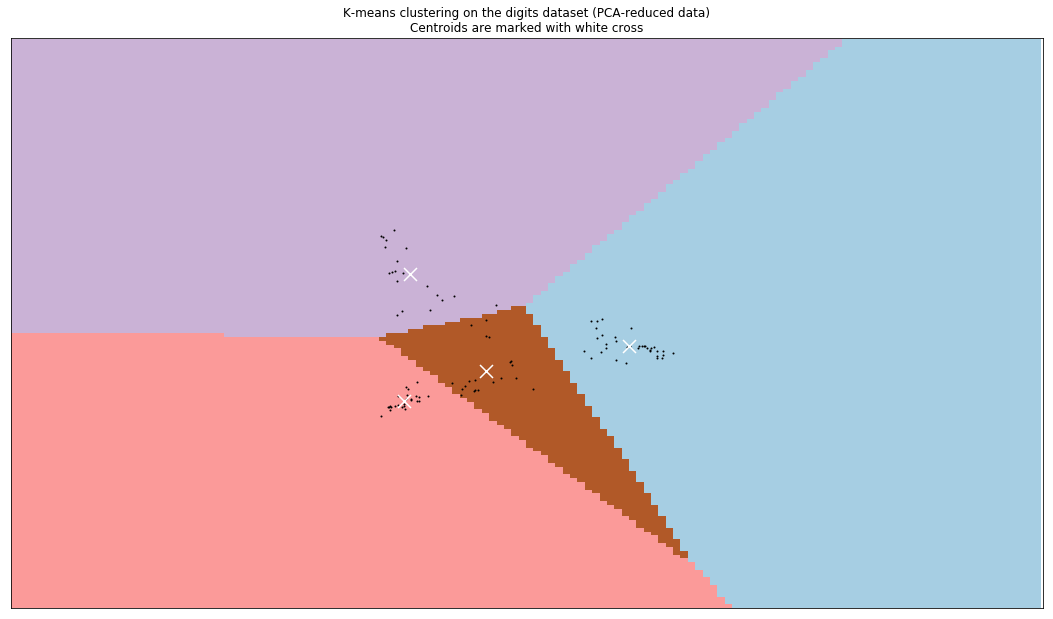

,0,1
0,判决如下:驳回上诉，维持原判。二审案件受理费50元，由张金路负担（已交纳）。本判决为终审判决。,0
1,判决如下:一、被告人夏天虎犯故意伤害罪，判处有期徒刑十个月，缓刑一年。第 4 页夏天虎故意伤...,3
2,判决如下:驳回上诉，维持原判。第 3 页聂巧连、高德珍生命权、健康权、身体权纠纷二审民事判决...,0
3,判决如下:一、被告人李正成犯故意伤害罪，判处有期徒刑一年，缓刑二年（缓刑考验期自判决执行之日...,3
4,判决如下:一、被告人胡某3犯故意伤害罪，判处有期徒刑一年，缓刑一年零六个月。（缓刑考验期限自...,3
5,判决如下:一、被告薛建广于本判决生效后10日内赔偿原告张海宝各项损失594228元；二、驳回...,0
6,判决如下:一、被告人张春良犯故意伤害罪，判处有期徒刑七个月。（刑期自判决执行之日起计算，判决...,3
7,判决如下:被告人何某甲犯故意伤害罪，判处有期徒刑一年零九个月，缓刑二年。（缓刑考验期限，从判...,2
8,判决如下:一、被告人王铁柱犯故意伤害罪，判处有期徒刑十年。（刑期从判决执行之日起计算。判决执...,2
9,判决如下:被告人尹代超犯故意伤害罪，判处有期徒刑六个月，缓刑十个月。（缓刑考验期从判决确定之...,2


In [126]:
## tf-idf建模后K-means聚类
from time import time
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def clean(single_para,stopwords_clean):
    """
    将stopwords和每一段文本取差集，清洗数据
    param single_para:没清洗文本集中的每一段数据
    return list_clean:每一段清洗好的文本
    """
    list_clean = set(single_para).difference(set(stopwords_clean))
    return list_clean

def data_prepare(text_list):
    """
    把数据清理干净
    param text_list:没清洗过的文本列表
    return list_clean:清洗过的文本列表
    """
    table_segments_list = list(map(lambda x:jieba.lcut(x),text_list))
    stopwords = list(map(lambda x:x.strip("\n"),codecs.open('stopwords.txt', 'r', 'utf-8').readlines()))
    stopwords_clean = list(map(lambda x:x.strip("\r"),stopwords))
    list_clean = list(map(clean,table_segments_list,stopwords_clean))
    return list_clean

def tf_idf_scikit(words):
    """
    使用scikit-learn建立tf-idf模型
    param words:清洗过的文本列表
    return tf-idf:tf-idf词袋模型
    """
    
    # 将文本中的词语转换为词频矩阵 矩阵元素a[i][j] 表示j词在i类文本下的词频
    vectorizer = CountVectorizer()

    # 统计每个词语的tf-idf权值
    transformer = TfidfTransformer()

    # 第一个fit_transform是计算tf-idf 第二个fit_transform是将文本转为词频矩阵
    tfidf = transformer.fit_transform(vectorizer.fit_transform(words))

    # 获取词袋模型中的所有词语
    word = vectorizer.get_feature_names()

    # 将tf-idf矩阵抽取出来，元素w[i][j]表示j词在i类文本中的tf-idf权重
    weight = tfidf.toarray()
    return weight

def classifier(weight,clusters_num):
    """
    使用
    param weight:tf-idf的权重
    param clusters_num:分类簇心数量
    return list_classification:文本与分类结果列表
    """
    list_classification = []
    ## 设计随机种子
    random_status = random.randint(1,1000)

    ## 建立Kmeans分类器
    clf = KMeans(init='k-means++',n_clusters = clusters_num,random_state = random_status,n_init=10)

    ## PCA降维处理
    reduced_data = pca(weight)

    ## 训练
    s = clf.fit(reduced_data)
    
    ## 参数显示
    # print(np.shape(clf.cluster_centers_)) #簇心
    print("标签数量",clf.labels_) 
    print("簇心之间的平均欧氏距离",clf.inertia_) #簇心之间的欧氏距离

    ## 文章归类处理
    i = 1
    while i <= len(clf.labels_):
        list_classification.append(clf.labels_[i-1])
        i = i + 1
    return list_classification,clf

def pca(weights):
    reduced_data = PCA(n_components=2).fit_transform(weights)
    return reduced_data

def ploting(reduced_data,clf): 
    
    h = .02
    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

    # Plot the centroids as a white X
    centroids = clf.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()

## 得到判决表
def data_input(table):
    """
    引入文本材料
    Param table:目标列表
    return table_judgements:含有目标文本的list
    """
    table_judgements = table["法院判决"].dropna()
    return table_judgements

table_judgements = data_input(table_final_2)

## 使用一百篇篇文章来做测试
data_test = data_prepare(list(table_judgements))[0:100] 

## 单词列表组成字符串
words = list(map(lambda x:" ".join(list(x)),data_test))

## tf-idf转换weight
weight = tf_idf_scikit(words)

## 分类器得到分类
list_classification,clf = classifier(weight,4)

## pca降维
reduced_data = pca(weight)

## 将分类情况可视化
ploting(reduced_data,clf)

## 将分类结果形成列表
pd.DataFrame([list(table_judgements[0:100]),list_classification]).T

### 使用神经网络分类（RNN，初步分类）
* 该方法只适用于判断某一类文本
* 回答如“是否该文本里，法院支不支持正当防卫”诸如此类的问题
* 但这个方法需要使用大量人工标注的文本，因此需要等大家做完很多题目以后，进行神经网络训练

In [33]:
import pickle
import os
os.chdir("正当防卫的1000份文书")
with open("corpus.pickle", 'rb') as f:
    corpus = pickle.load(f)
table_final_2 = pd.read_excel("final_table_2.xlsx")

In [37]:
import pandas as pd
import numpy as np
import gensim
from gensim.models import word2vec
import re
import os
import tensorflow as tf

In [3]:
os.path.abspath(".")
os.chdir("word2vec-nlp-tutorial")
data_t = pd.read_csv("labeledTrainData.tsv",sep = "\t")
del data_t["id"]

In [4]:
## 训练word_vec模型
if not os.path.exists("mymodel"):
    if not os.path.exists("imdb_text"):
        data_un = pd.read_csv("unlabeledTrainData.tsv",
                             headers = 0,
                             delimiter = "\t",
                             quoting = 3)
        pat = re.compile(r"[A-Za-z]+|[!?,:().]")
        with open("imdb_text","a",encoding = "utf-8") as f:
            for rev in data_un.review:
                str_list = pat.findall(rev)
                str_list = [x.lower() for x in str_list]
                string = " ".join(str_list)
                f.write(string + "\n")
            del data_un
    sentences = word2vec.Text8Corpus("imdb_text")
    model = word2vec.Word2Vec(sentences,size = 50)
    
    # 训练skip-gram模型，默认window = 5
    model.save("mymodel")
else:
    model = word2vec.Word2Vec.load("mymodel")

In [5]:
word_vectors = model.wv
del model
data_t["vec"] = data_t.review.apply(lambda x:[word_vectors[w] for w in x.split() if w in word_vectors])

In [6]:
np.shape(data_t.head().vec[0])
del data_t['review']
del word_vectors

In [7]:
import gc
gc.collect()

21

In [8]:
data_t = data_t[data_t["vec"].apply(lambda x:len(x) > 0)]
data_t.sentiment.value_counts()
maxlength = max([len(x) for x in data_t.vec])
maxlength
# 评价为1，正面的12499
# 负面为0，负面的12495
# 有几个没有被训练出词向量

1622

In [9]:
sum(data_t.vec.apply(len) > 300)
## 填充评论长度
def pad(x):
    if len(x) > 300:
        x1 = x[:300] # 超过300的，截取0：300的
    else:
        x1 = np.zeros((300,50))
        x1[:len(x)] = x # 不满300的，就直接填充0
    return x1

In [10]:
data_t["vec"] = data_t.vec.apply(pad)
data_t.vec.head()[0]
np.shape(data_t.sentiment.values)

(24994,)

In [11]:
### RNN部分
import tensorflow as tf
learning_rate = 0.002
batch_size = 100
n_input = 50
n_steps = 300
n_hidden = 300
n_classes = 2

# RNN的输入维度，为3个维度，第一维度为输入的批次
# 第二维度为输入step，word-vector的长度，或者说文本的顺序
# 第三维度为输入单词向量，每个单词以50个向量来表示
# [批次,step,input]

In [12]:
x = tf.placeholder(tf.float32,[None,n_steps,n_input])
y = tf.placeholder(tf.int64,[None])
keep_prob = tf.placeholder("float")

In [13]:
def length(shuru):
    return tf.reduce_sum(tf.sign(tf.reduce_max(tf.abs(shuru),reduction_indices = 2)),reduction_indices = 1)
# 找出真正长度

In [14]:
cell = tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.GRUCell(n_hidden,
                                    kernel_initializer = tf.truncated_normal_initializer(stddev = 0.0001),
                                    bias_initializer = tf.truncated_normal_initializer(stddev = 0.0001)),
                                    output_keep_prob = keep_prob)

In [15]:
output,_ = tf.nn.dynamic_rnn(
           cell,
           x,
           dtype = tf.float32,
           sequence_length = length(x))

In [16]:
output.get_shape()
index = tf.range(0,batch_size) * n_steps + (tf.cast(length(x),tf.int32) - 1)
flat = tf.reshape(output,[-1,int(output.get_shape()[2])])
last = tf.gather(flat,index)

In [17]:
weight = tf.Variable(tf.truncated_normal((n_hidden,n_classes),stddev = 0.001))
bias = tf.Variable(tf.constant(0.1,shape = [n_classes]))
com_out = tf.matmul(last,weight) + bias
prediction = tf.nn.softmax(com_out) ## 用来计算准确率

In [18]:
cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y,logits = com_out))

In [19]:
optimizer = tf.train.AdamOptimizer(learning_rate)
grads = optimizer.compute_gradients(cross_entropy) # 梯度裁剪
for i,(g,v) in enumerate(grads):
    if g is not None:
        grads[i] = (tf.clip_by_norm(g,5),v)
train_op = optimizer.apply_gradients(grads)

C:\Users\dfuser.DELLCFFN202\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [20]:
correct_pred = tf.equal(tf.argmax(prediction,1),y)
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

In [21]:
### 产生批次
def generatebatch(X,Y,n_examples,batch_size):
    for batch_i in range(n_examples // batch_size):
        start = batch_i * batch_size
        end = start + batch_size
        batch_xs = X[start:end]
        batch_ys = Y[start:end]
        yield batch_xs,batch_ys

In [22]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
saver = tf.train.Saver()

In [24]:
ii = 0
for step in range(10):
    index = np.random.permutation(int(len(data_t.vec.values)))
    for batch_x,batch_y in generatebatch(data_t.vec.values[index],data_t.sentiment.values[index],len(data_t.vec.values),batch_size):
        batch_x = np.concatenate(batch_x).reshape(batch_size,300,50)
        batch_x.astype(np.float64)
        sess.run(train_op,feed_dict = {x:batch_x,y:batch_y,keep_prob:0.5})
        loss = sess.run(cross_entropy,feed_dict = {x:batch_x,y:batch_y,keep_prob:1})
        print(loss)
    acc = sess.run(accuracy,feed_dict = {x:batch_x,y:batch_y,keep_prob:1})
    loss = sess.run(cross_entropy,feed_dict = {x:batch_x,y:batch_y,keep_prob:1})
    #saver.save(sess,'./teansorflow',global_step = step)
    print("Iter " + str(step) + ",Minibatch Loss= ".format(loss) + "{}".format(acc))
print("Optimization Finished")

0.33937696
0.42835575
0.47523037
0.3617033
0.34357166
0.40983632
0.422715
0.49003926
0.42240238
0.34814534


KeyboardInterrupt: 